# **Faster RCNN**

# **2-1 Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import os
import torch
import torch.optim as optim
import copy
import torchvision.transforms as T
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torch import nn
from tensorflow.keras import layers, models
from PIL import Image
from torch.autograd import Variable
from tqdm import tqdm

import torch.nn as nn
import xml.etree.ElementTree as ET
import xml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations
import cv2
import tensorflow as tf
import torchvision
import torchvision.ops as ops
import torch.nn.functional as F

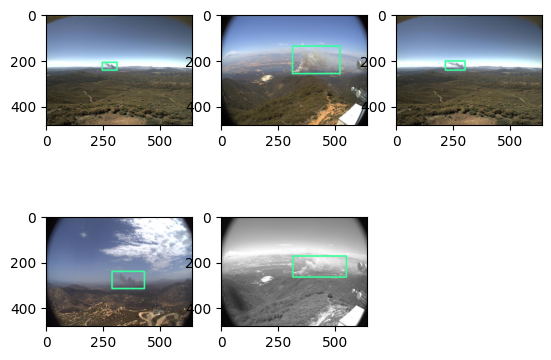

In [35]:
def getPrint():

  ds_data = []
  ds_annotation = []
  path = "/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/train/"
  image_path=path
  annotation_path=path

  files_name = os.listdir(image_path)
  cnt = 0
  for filename_ in files_name:
    if cnt >= 5:
      break
    filename, extension= os.path.splitext(filename_)
    img_path =image_path+filename+'.jpg'
    xml_path =annotation_path+filename+'.xml'
    img = cv2.imread(img_path)
    if (filename+'.jpg') in files_name[0:cnt]:
      cnt = cnt + 1
    elif (filename+'.xml') in files_name[0:cnt]:
      cnt = cnt + 1
    else:
      ds_data.append(img)
      dom=xml.dom.minidom.parse(xml_path)
      root = dom.documentElement
      objects=dom.getElementsByTagName("object")
      i = 0
      for object in objects:
        bndbox = root.getElementsByTagName('bndbox')[i]
        xmin = bndbox.getElementsByTagName('xmin')[0]
        ymin = bndbox.getElementsByTagName('ymin')[0]
        xmax = bndbox.getElementsByTagName('xmax')[0]
        ymax = bndbox.getElementsByTagName('ymax')[0]
        xmin_data=xmin.childNodes[0].data
        ymin_data=ymin.childNodes[0].data
        xmax_data=xmax.childNodes[0].data
        ymax_data=ymax.childNodes[0].data
        ds_annotation.append([xmin_data, ymin_data, xmax_data, ymax_data])
        i = i + 1
      cnt = cnt + 1

  for k in range(0, 5):
    img = cv2.cvtColor(ds_data[k].astype(np.uint8), cv2.COLOR_BGR2RGB)
    cv2.rectangle(img,(int(ds_annotation[k][0]),int(ds_annotation[k][1])),(int(ds_annotation[k][2]),int(ds_annotation[k][3])),(55,255,155),5)
    plt.subplot(2, 3, k+1)
    plt.imshow(img)

  plt.show()

  return

getPrint()

In [4]:
def resize_image(img_arr, bboxes, h, w):
    """
    :param img_arr: original image as a numpy array
    :param bboxes: bboxes as numpy array where each row is 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
    :param h: resized height dimension of image
    :param w: resized weight dimension of image
    :return: dictionary containing {image:transformed, bboxes:['x_min', 'y_min', 'x_max', 'y_max', "class_id"]}
    """
    # create resize transform pipeline
    transform = albumentations.Compose(
        [albumentations.Resize(height=h, width=w, always_apply=True)],
        bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['category_ids']))

    transformed = transform(image=img_arr, bboxes=[bboxes], category_ids=[1])
    return transformed['image'], np.array(transformed['bboxes'])

In [5]:
# Custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_folder = root
        self.label_folder = root
        self.image_names = [name for name in os.listdir(self.image_folder) if name.endswith(".jpg")]

    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.image_folder, img_name)
        label_path = os.path.join(self.label_folder, img_name.replace(".jpg", ".xml"))

        # image = Image.open(img_path).convert("RGB")
        image = cv2.imread(img_path)
        target = self.parse_xml(label_path)
        image, target = resize_image(image, np.array(target['boxes'][0]), 224, 224)

        image = torch.from_numpy(np.array(image)).permute(2, 0, 1).to(dtype=torch.float32)
        target = torch.from_numpy(np.array(target))

        return image, target

    def __len__(self):
        return len(self.image_names)

    def parse_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming a single class for simplicity

        return {'boxes': torch.tensor(boxes, dtype=torch.float32),
                'labels': torch.tensor(labels, dtype=torch.int64)}

In [6]:
# Instantiate the dataset
dataset = CustomDataset(root="/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/train/")
# Define data loader
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [7]:
# Instantiate the dataset
datasetval = CustomDataset(root="/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/valid/")
# Define data loader
val_data_loader = DataLoader(datasetval, batch_size=2, shuffle=True)

In [8]:
# Instantiate the dataset
datasettst = CustomDataset(root="/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/test/")
# Define data loader
tst_data_loader = DataLoader(datasettst, batch_size=2, shuffle=True)

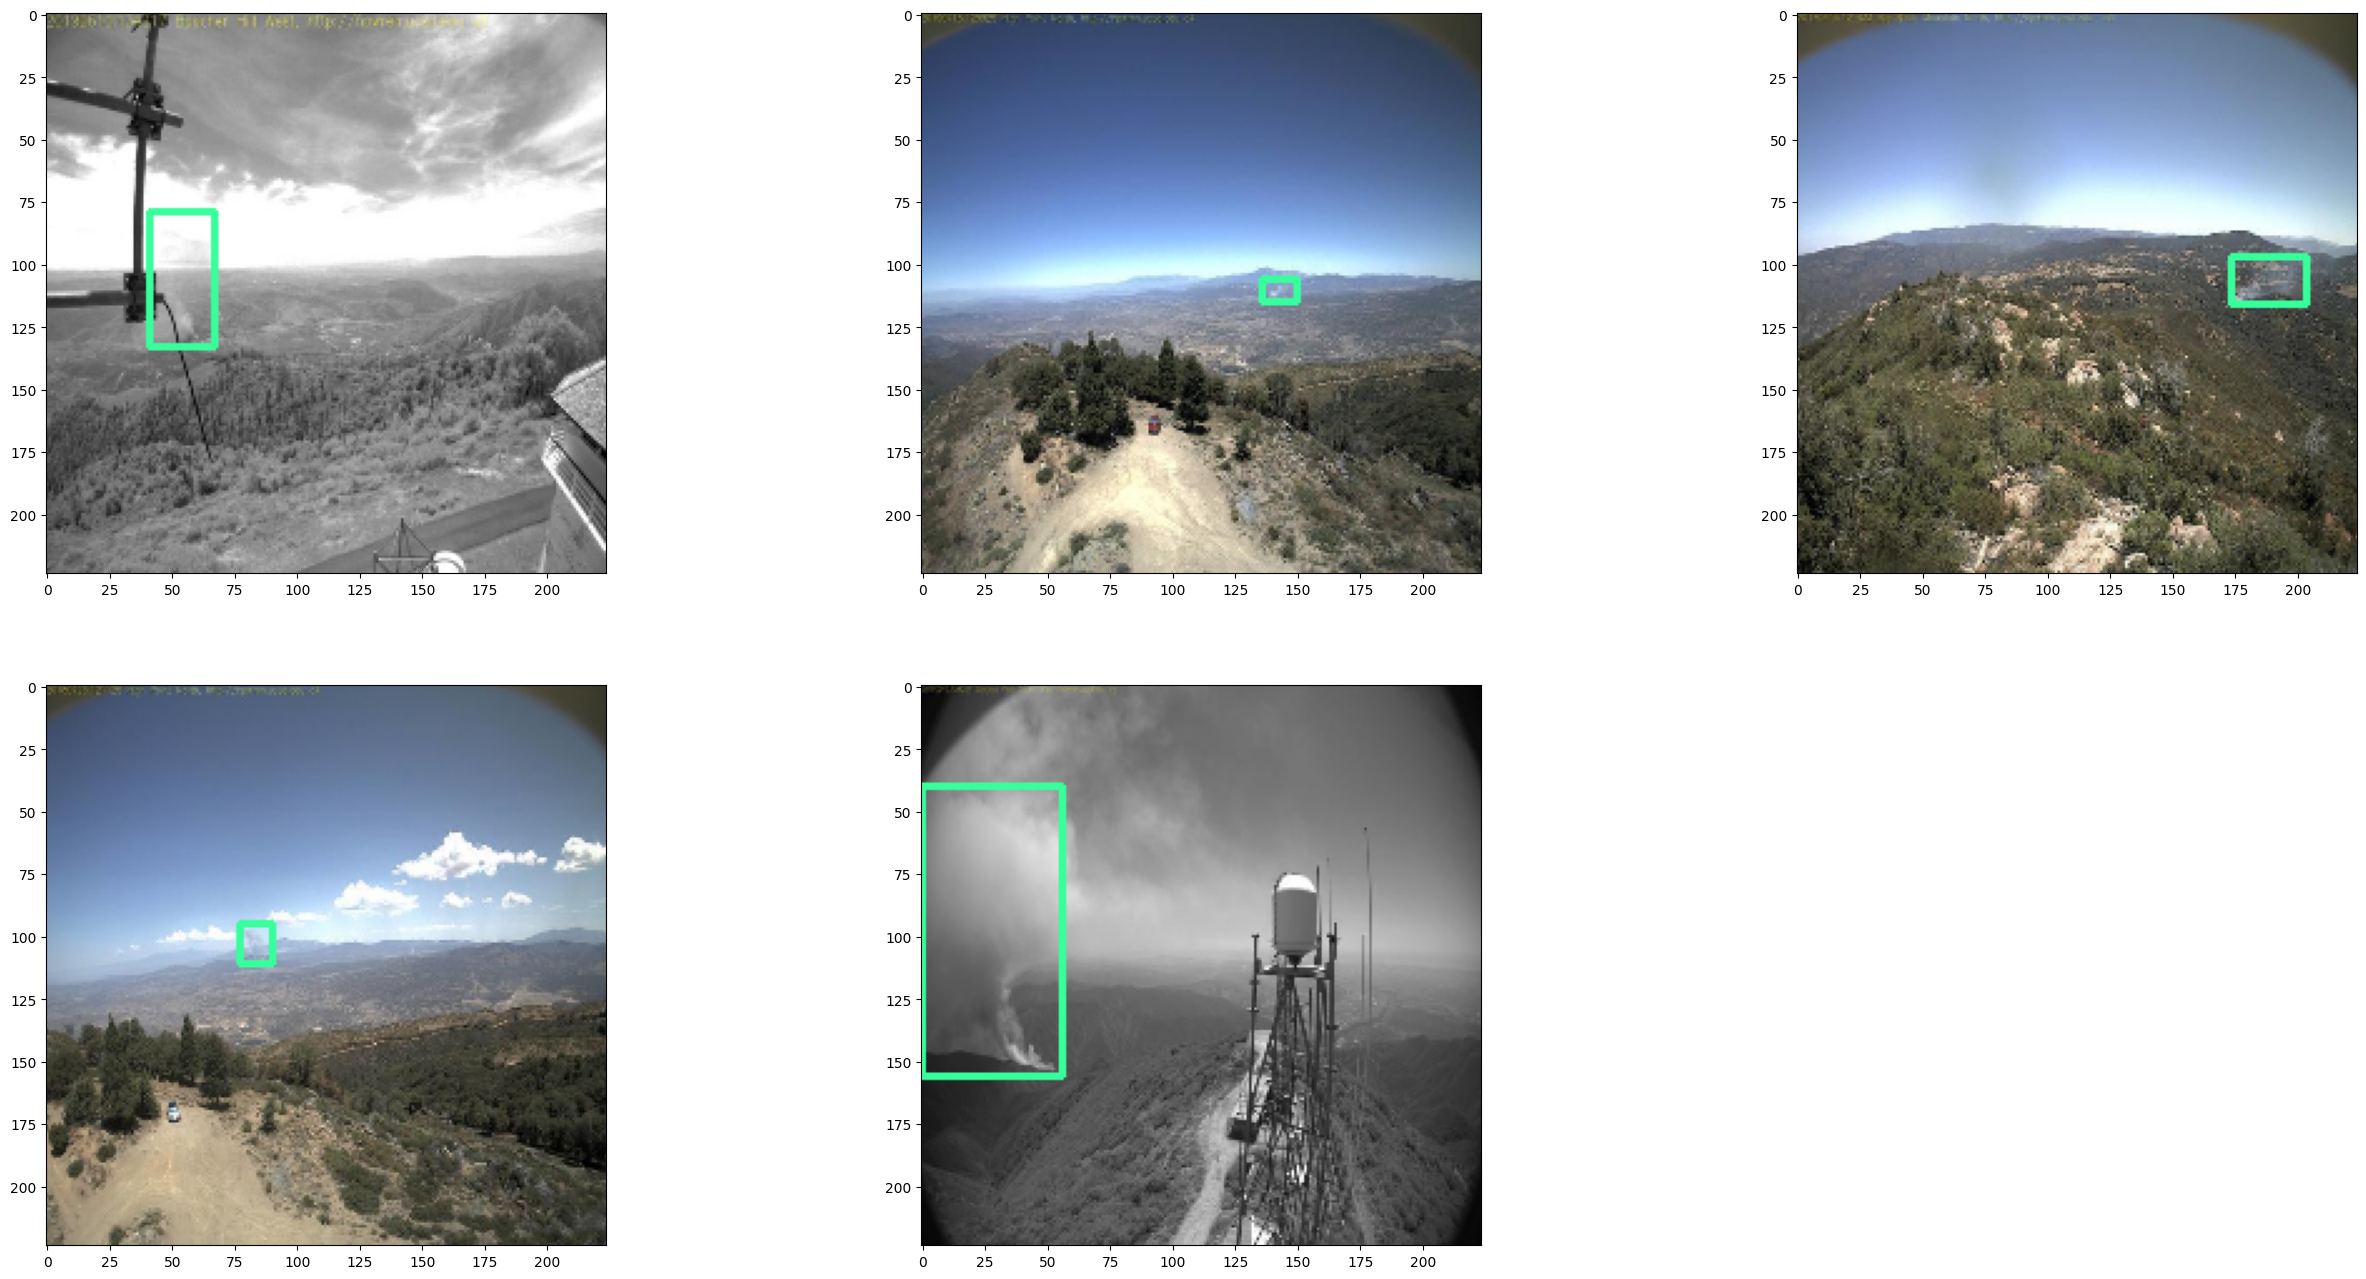

In [36]:
data_loader_copy = copy.deepcopy(data_loader)
plt.figure(figsize=(32,16))

k = 0
for image, bbox in data_loader_copy:
  img = cv2.cvtColor(image[0].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_BGR2RGB)
  cv2.rectangle(img,(int(bbox[0][0][0]),int(bbox[0][0][1])),(int(bbox[0][0][2]),int(bbox[0][0][3])),(55,255,155),2)
  plt.subplot(2, 3, k+1)
  plt.imshow(img)
  k+=1
  if k >= 5:
    break

plt.show()

In [10]:
vgg16 = torchvision.models.vgg16(pretrained=True)
backbone = vgg16.features[0:-1]

# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = False

for img, target in data_loader_copy:
  out = backbone(img)
  break

out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
width_scale_factor = 224 // out_w
height_scale_factor = 224 // out_h
height_scale_factor, width_scale_factor

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(16, 16)

In [11]:
def gen_anc_centers(out_size):
    out_h, out_w = out_size

    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5

    return anc_pts_x, anc_pts_y

def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0), anc_pts_y.size(dim=0), n_anc_boxes, 4)

    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale

                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)

    return anc_base

def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']

    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes

    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor

    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)

    return proj_bboxes

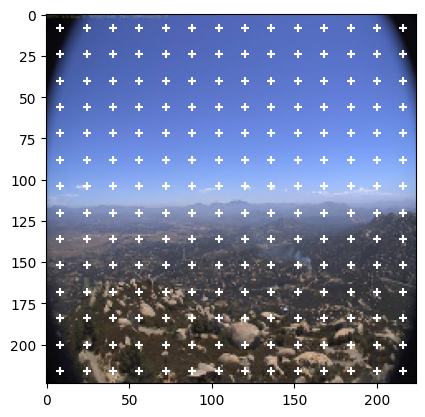

In [12]:
anc_pts_x, anc_pts_y = gen_anc_centers((out_h, out_w))
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

for img, target in data_loader_copy:
  img = cv2.cvtColor(image[0].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  for x in anc_pts_x_proj:
        for y in anc_pts_y_proj:
            plt.scatter(x, y, color="w", marker='+')

  break

In [13]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios)

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(516, 1, 1, 1, 1)

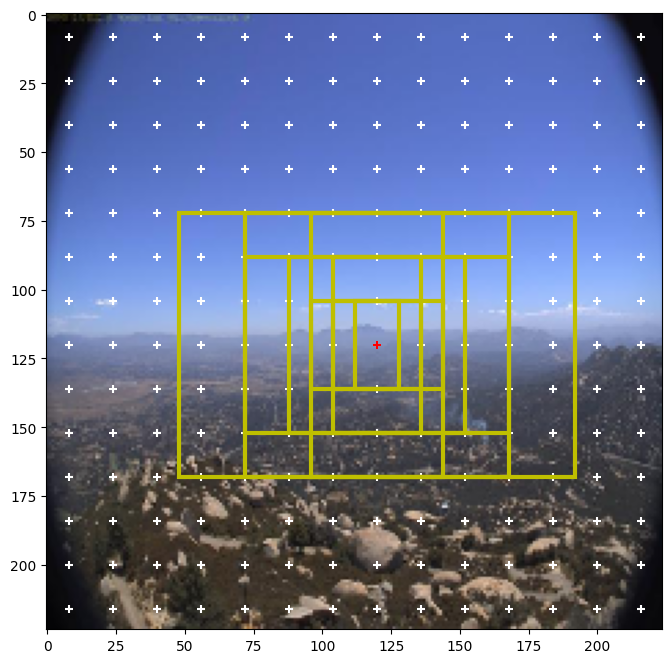

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(16, 8))
for img, target in data_loader_copy:
  img = cv2.cvtColor(image[0].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  anc_boxes_proj = project_bboxes(anc_base, width_scale_factor, height_scale_factor, mode='a2p')

  break

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [7, 7]
bboxes = anc_boxes_proj[0][sp_1[0], sp_1[1]]

for x in anc_pts_x_proj:
        for y in anc_pts_y_proj:
            plt.scatter(x, y, color="w", marker='+')
plt.scatter(anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]], color="red", marker='+')


bboxes = ops.box_convert(bboxes, in_fmt='xyxy', out_fmt='xywh')

for box in bboxes:
  x, y, w, h = box.numpy()
  # display bounding box
  rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='y', facecolor='none')
  axes.add_patch(rect)

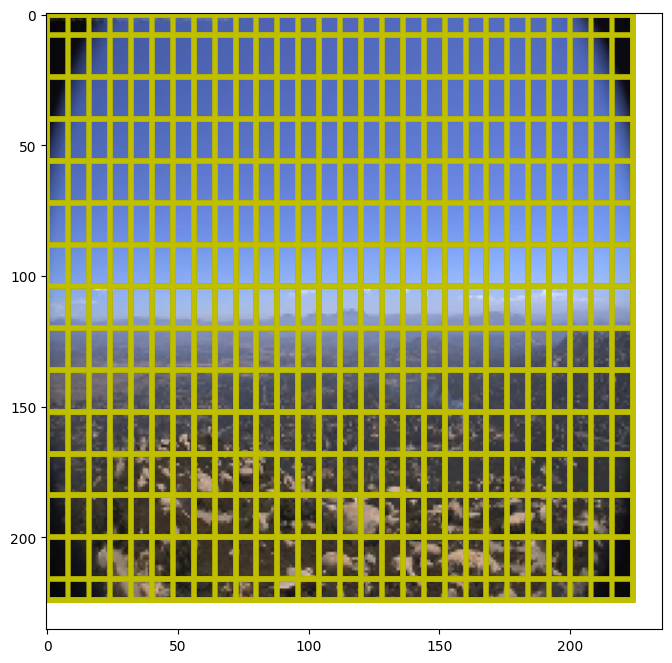

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(16, 8))
for img, target in data_loader_copy:
  img = cv2.cvtColor(image[0].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  anc_boxes_proj = project_bboxes(anc_base, width_scale_factor, height_scale_factor, mode='a2p')

  break

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [7, 7]
bboxes = anc_boxes_proj[0][sp_1[0], sp_1[1]]

for x in anc_pts_x_proj:
        for y in anc_pts_y_proj:
            plt.scatter(x, y, color="w", marker='+')
plt.scatter(anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]], color="red", marker='+')


for i in range(anc_pts_x_proj.size(dim=0)):
  for j in range(anc_pts_x_proj.size(dim=0)):
    bboxes = anc_boxes_proj[0][i, j]
    bboxes = ops.box_convert(bboxes, in_fmt='xyxy', out_fmt='xywh')
    for box in bboxes:
      x, y, w, h = box.numpy()
      # display bounding box
      rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='y', facecolor='none')
      axes.add_patch(rect)

# **Model**

In [16]:
# Loss Utils
def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
    target_pos = torch.ones_like(conf_scores_pos)
    target_neg = torch.zeros_like(conf_scores_neg)

    target = torch.cat((target_pos, target_neg))
    inputs = torch.cat((conf_scores_pos, conf_scores_neg))

    loss = F.binary_cross_entropy_with_logits(inputs, target, reduction='sum') * 1. / batch_size

    return loss

def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
    assert gt_offsets.size() == reg_offsets_pos.size()
    loss = F.smooth_l1_loss(reg_offsets_pos, gt_offsets, reduction='sum') * 1. / batch_size
    return loss

In [17]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.vgg16(pretrained=True)
        self.backbone = model.features[0:-1]
        # unfreeze all the parameters
        for param in backbone.named_parameters():
            param[1].requires_grad = False

    def forward(self, img_data):
        return self.backbone(img_data)

In [18]:
def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):

    # flatten anchor boxes
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)
    # get total anchor boxes for a single image
    tot_anc_boxes = anc_boxes_flat.size(dim=1)

    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.size(dim=1)))

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = gt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)

    return ious_mat

def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)


def generate_proposals(anchors, offsets):

    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):
    '''
    Prepare necessary data required for training

    Input
    ------
    anc_boxes_all - torch.Tensor of shape (B, w_amap, h_amap, n_anchor_boxes, 4)
        all anchor boxes for a batch of images
    gt_bboxes_all - torch.Tensor of shape (B, max_objects, 4)
        padded ground truth boxes for a batch of images
    gt_classes_all - torch.Tensor of shape (B, max_objects)
        padded ground truth classes for a batch of images

    Returns
    ---------
    positive_anc_ind -  torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    negative_anc_ind - torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    GT_conf_scores - torch.Tensor of shape (n_pos,), IoU scores of +ve anchors
    GT_offsets -  torch.Tensor of shape (n_pos, 4),
        offsets between +ve anchors and their corresponding ground truth boxes
    GT_class_pos - torch.Tensor of shape (n_pos,)
        mapped classes of +ve anchors
    positive_anc_coords - (n_pos, 4) coords of +ve anchors (for visualization)
    negative_anc_coords - (n_pos, 4) coords of -ve anchors (for visualization)
    positive_anc_ind_sep - list of indices to keep track of +ve anchors
    '''
    anc_boxes_all = anc_boxes_all.to("cuda")
    gt_bboxes_all = gt_bboxes_all.to("cuda")
    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1] # max number of groundtruth bboxes in a batch

    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap

    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)

    # for every groundtruth bbox in an image, find the iou
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)

    # get positive anchor boxes

    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0)
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)

    positive_anc_ind_sep = torch.where(positive_anc_mask)[0] # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]

    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)

    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]

    # get gt classes of the +ve anchor boxes

    # expand gt classes to map against every anchor box
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N)
    gt_classes_expand = gt_classes_expand.to("cuda")
    max_iou_per_anc_ind = max_iou_per_anc_ind.to("cuda")
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]

    # get gt bbox coordinates of the +ve anchor boxes

    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]

    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2) # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]

    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)

    # get -ve anchors

    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]

    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep

In [19]:
class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super().__init__()
        self.n_anchors = n_anchors
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim, n_anchors, kernel_size=1) # must be 2*n_anchors
        self.reg_head = nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)

    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        # determine mode
        if pos_anc_ind is None or neg_anc_ind is None or pos_anc_coords is None:
            mode = 'eval'
        else:
            mode = 'train'

        out = self.conv1(feature_map)
        out = F.relu(self.dropout(out))

        reg_offsets_pred = self.reg_head(out) # (B, A*4, hmap, wmap)
        conf_scores_pred = self.conf_head(out) # (B, A, hmap, wmap)

        if mode == 'train':
            # get conf scores
            conf_scores_pos = conf_scores_pred.flatten()[pos_anc_ind]
            conf_scores_neg = conf_scores_pred.flatten()[neg_anc_ind]
            # get offsets for +ve anchors
            offsets_pos = reg_offsets_pred.contiguous().view(-1, 4)[pos_anc_ind]
            # generate proposals using offsets
            proposals = generate_proposals(pos_anc_coords, offsets_pos)

            return conf_scores_pos, conf_scores_neg, offsets_pos, proposals

        elif mode == 'eval':
            return conf_scores_pred, reg_offsets_pred

In [20]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super().__init__()

        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size

        # downsampling scale factor
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h

        # scales and ratios for anchor boxes
        self.anc_scales = [2, 4, 6]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)

        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3

        # weights for loss
        self.w_conf = 1
        self.w_reg = 5

        self.feature_extractor = FeatureExtractor()
        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)

    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(dim=0)
        feature_map = self.feature_extractor(images)

        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        anc_pts_x = anc_pts_x.to("cuda")
        anc_pts_y = anc_pts_y.to("cuda")
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_base = anc_base.to("cuda")
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        anc_boxes_all = anc_boxes_all.to("cuda")

        # get positive and negative anchors amongst other things
        gt_bboxes_proj = project_bboxes(gt_bboxes, self.width_scale_factor, self.height_scale_factor, mode='p2a')

        positive_anc_ind, negative_anc_ind, GT_conf_scores, \
        GT_offsets, GT_class_pos, positive_anc_coords, \
        negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes.to("cuda"))

        # pass through the proposal module
        conf_scores_pos, conf_scores_neg, offsets_pos, proposals = self.proposal_module(feature_map, positive_anc_ind, \
                                                                                        negative_anc_ind, positive_anc_coords)

        cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
        reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)

        total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss

        return total_rpn_loss, feature_map, proposals, positive_anc_ind_sep, GT_class_pos

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        with torch.no_grad():
            batch_size = images.size(dim=0)
            feature_map = self.feature_extractor(images)

            # generate anchors
            anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
            anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
            anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
            anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)


            # get conf scores and offsets
            conf_scores_pred, offsets_pred = self.proposal_module(feature_map)
            conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
            offsets_pred = offsets_pred.reshape(batch_size, -1, 4)
            # filter out proposals based on conf threshold and nms threshold for each image
            proposals_final = []
            conf_scores_final = []
            for i in range(batch_size):
                conf_scores = torch.sigmoid(conf_scores_pred[i])
                offsets = offsets_pred[i]
                anc_boxes = anc_boxes_flat[i]
                proposals = generate_proposals(anc_boxes, offsets)
                # filter based on confidence threshold
                conf_idx = torch.where(conf_scores >= conf_thresh)[0]
                conf_scores_pos = conf_scores[conf_idx]
                proposals_pos = proposals[conf_idx]
                # filter based on nms threshold
                nms_idx = ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
                conf_scores_pos = conf_scores_pos[nms_idx]
                proposals_pos = proposals_pos[nms_idx]

                proposals_final.append(proposals_pos)
                conf_scores_final.append(conf_scores_pos)

        return proposals_final, conf_scores_final, feature_map


In [21]:
class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()
        self.roi_size = roi_size
        # hidden network
        self.avg_pool = nn.AvgPool2d(self.roi_size)
        self.fc = nn.Linear(out_channels, hidden_dim)
        self.dropout = nn.Dropout(p_dropout)

        # define classification head
        self.cls_head = nn.Linear(hidden_dim, n_classes)

    def forward(self, feature_map, proposals_list, gt_classes=None):

        if gt_classes is None:
            mode = 'eval'
        else:
            mode = 'train'

        # apply roi pooling on proposals followed by avg pooling
        roi_out = ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)

        # flatten the output
        roi_out = roi_out.squeeze(-1).squeeze(-1)

        # pass the output through the hidden network
        out = self.fc(roi_out)
        out = F.relu(self.dropout(out))

        # get the classification scores
        cls_scores = self.cls_head(out)

        if mode == 'eval':
            return cls_scores

        # compute cross entropy loss
        gt_classes_reshaped = torch.reshape(gt_classes.long(), (len(gt_classes.long()), 1))
        cls_loss = F.cross_entropy(cls_scores, gt_classes_reshaped.float()) #gt_classes.long())
        return cls_loss

In [22]:
class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
        super().__init__()
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)

    def forward(self, images, gt_bboxes, gt_classes):
        total_rpn_loss, feature_map, proposals, \
        positive_anc_ind_sep, GT_class_pos = self.rpn(images, gt_bboxes, gt_classes)
        # get separate proposals for each sample
        pos_proposals_list = []
        batch_size = images.size(dim=0)
        for idx in range(batch_size):
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)

        cls_loss = self.classifier(feature_map, pos_proposals_list, GT_class_pos)
        total_loss = cls_loss + total_rpn_loss

        return total_loss

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        batch_size = images.size(dim=0)
        proposals_final, conf_scores_final, feature_map = self.rpn.inference(images, conf_thresh, nms_thresh)
        cls_scores = self.classifier(feature_map, proposals_final)

        # convert scores into probability
        cls_probs = F.softmax(cls_scores, dim=-1)
        # get classes with highest probability
        classes_all = torch.argmax(cls_probs, dim=-1)

        classes_final = []
        # slice classes to map to their corresponding image
        c = 0
        for i in range(batch_size):
            n_proposals = len(proposals_final[i]) # get the number of proposals for each image
            classes_final.append(classes_all[c: c+n_proposals])
            c += n_proposals

        return proposals_final, conf_scores_final, classes_final

# **Train**

In [23]:
img_height = img_width = 224
name2idx = {'pad': -1, 'smoke': 1}
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [24]:
data_loader_check = copy.deepcopy(data_loader)

In [25]:
for img_batch, gt_bboxes_batch in data_loader_check:
  break
gt_classes_batch = torch.tensor([[1.0], [1.0]])

In [26]:
def training_loop(model, learning_rate, train_dataloader, val_data_loader, n_epochs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    loss_list = []
    val_loss_list = []
    cnt = 0
    for i in tqdm(range(n_epochs)):
        # TRAIN ##########################################################################################
        total_loss = 0
        cnt = 0
        for img_batch, gt_bboxes_batch in train_dataloader:
            cnt = cnt + 1
            gt_classes_batch = torch.tensor([[1.0], [1.0]])
            # forward pass
            loss = model(img_batch.to(device), gt_bboxes_batch.to(device), gt_classes_batch.to(device))
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        loss_list.append(total_loss/(cnt))

        # VALIDATION #####################################################################################
        val_total_loss = 0
        cnt = 0
        with torch.no_grad():
          for img_batchv, gt_bboxes_batchv in val_data_loader:
            cnt = cnt + 1
            if (img_batchv.shape[0] == 2):
              gt_classes_batchV = torch.tensor([[1.0], [1.0]])
            else:
              gt_classes_batchV = torch.tensor([[1.0]])
            # forward pass
            lossval = model(img_batchv.to(device), gt_bboxes_batchv.to(device), gt_classes_batchV.to(device))
            # backpropagation

            val_total_loss += lossval.item()
          val_loss_list.append(val_total_loss/(cnt))

        print("Loss of epoch ", i, "- Train:", loss_list[-1], " and validation: ", val_loss_list[-1])

    return loss_list, val_loss_list

In [27]:
data_loader_train = copy.deepcopy(data_loader)

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device is: ", device)
learning_rate = 1e-4
n_epochs = 50

loss_list, val_loss_list = training_loop(detector.to(device), learning_rate, data_loader_train, val_data_loader, n_epochs)

device is:  cuda


  2%|▏         | 1/50 [02:07<1:43:44, 127.04s/it]

Loss of epoch  0 - Train: 4.145937997645899  and validation:  3.4135564337446027


  4%|▍         | 2/50 [04:09<1:39:33, 124.45s/it]

Loss of epoch  1 - Train: 3.3508367246240893  and validation:  3.448164892916939


  6%|▌         | 3/50 [06:12<1:36:58, 123.79s/it]

Loss of epoch  2 - Train: 3.0268534145715904  and validation:  3.3653765732206384


  8%|▊         | 4/50 [08:15<1:34:33, 123.34s/it]

Loss of epoch  3 - Train: 2.696670248377008  and validation:  3.0889110617957964


 10%|█         | 5/50 [10:17<1:32:18, 123.08s/it]

Loss of epoch  4 - Train: 2.4948723694756425  and validation:  2.9095102112479276


 12%|█▏        | 6/50 [12:20<1:30:04, 122.83s/it]

Loss of epoch  5 - Train: 2.325692376805787  and validation:  3.1663888424849147


 14%|█▍        | 7/50 [14:22<1:27:59, 122.77s/it]

Loss of epoch  6 - Train: 2.1778307114966067  and validation:  2.533698480280601


 16%|█▌        | 8/50 [16:25<1:25:47, 122.55s/it]

Loss of epoch  7 - Train: 2.0184949170227955  and validation:  2.7135075997660927


 18%|█▊        | 9/50 [18:27<1:23:46, 122.59s/it]

Loss of epoch  8 - Train: 1.933404893674604  and validation:  2.2558040843222034


 20%|██        | 10/50 [20:29<1:21:39, 122.50s/it]

Loss of epoch  9 - Train: 1.884875987570239  and validation:  2.2065404968102307


 22%|██▏       | 11/50 [22:32<1:19:41, 122.61s/it]

Loss of epoch  10 - Train: 1.6695897635662416  and validation:  1.9118038839009148


 24%|██▍       | 12/50 [24:35<1:17:39, 122.62s/it]

Loss of epoch  11 - Train: 1.6749646593722605  and validation:  2.0882869541331077


 26%|██▌       | 13/50 [26:38<1:15:36, 122.61s/it]

Loss of epoch  12 - Train: 1.4949004457654662  and validation:  1.8936209668580095


 28%|██▊       | 14/50 [28:39<1:13:25, 122.37s/it]

Loss of epoch  13 - Train: 1.4709290630688105  and validation:  1.6919978204789399


 30%|███       | 15/50 [30:42<1:11:25, 122.43s/it]

Loss of epoch  14 - Train: 1.37034173673698  and validation:  1.6616744819597364


 32%|███▏      | 16/50 [32:45<1:09:26, 122.54s/it]

Loss of epoch  15 - Train: 1.4323865059507894  and validation:  1.6596996605444279


 34%|███▍      | 17/50 [34:47<1:07:22, 122.50s/it]

Loss of epoch  16 - Train: 1.420680793925359  and validation:  1.6385141032632966


 36%|███▌      | 18/50 [36:50<1:05:18, 122.45s/it]

Loss of epoch  17 - Train: 1.1710312997756283  and validation:  1.7972263130289823


 38%|███▊      | 19/50 [38:52<1:03:16, 122.47s/it]

Loss of epoch  18 - Train: 1.105868438839116  and validation:  1.8529218214949263


 40%|████      | 20/50 [40:55<1:01:20, 122.70s/it]

Loss of epoch  19 - Train: 1.2021135405451138  and validation:  1.67007734415937


 42%|████▏     | 21/50 [42:58<59:16, 122.65s/it]  

Loss of epoch  20 - Train: 1.0841920650207673  and validation:  1.4591462996843871


 44%|████▍     | 22/50 [45:00<57:12, 122.59s/it]

Loss of epoch  21 - Train: 0.976418082124852  and validation:  1.5624261860887594


 46%|████▌     | 23/50 [47:02<55:02, 122.33s/it]

Loss of epoch  22 - Train: 0.8847081260753785  and validation:  1.3665051007561833


 48%|████▊     | 24/50 [49:04<52:57, 122.23s/it]

Loss of epoch  23 - Train: 0.9610908344406117  and validation:  1.3973626801184864


 50%|█████     | 25/50 [51:07<51:00, 122.43s/it]

Loss of epoch  24 - Train: 0.8990861529425477  and validation:  1.3952636246176888


 52%|█████▏    | 26/50 [53:10<49:02, 122.60s/it]

Loss of epoch  25 - Train: 0.8180236253529107  and validation:  1.317453343980312


 54%|█████▍    | 27/50 [55:13<47:00, 122.63s/it]

Loss of epoch  26 - Train: 0.7262118260431564  and validation:  1.6127815097952143


 56%|█████▌    | 28/50 [57:15<44:59, 122.71s/it]

Loss of epoch  27 - Train: 0.7648733159202424  and validation:  1.3084746007845847


 58%|█████▊    | 29/50 [59:18<42:54, 122.61s/it]

Loss of epoch  28 - Train: 0.7206568372786609  and validation:  1.1860302361584134


 60%|██████    | 30/50 [1:01:21<40:53, 122.68s/it]

Loss of epoch  29 - Train: 0.7079793086805718  and validation:  1.3753340225554402


 62%|██████▏   | 31/50 [1:03:23<38:47, 122.50s/it]

Loss of epoch  30 - Train: 0.7450126623139808  and validation:  1.1538989954805836


 64%|██████▍   | 32/50 [1:05:25<36:42, 122.35s/it]

Loss of epoch  31 - Train: 0.685771747817543  and validation:  1.3220724172367582


 66%|██████▌   | 33/50 [1:07:27<34:38, 122.26s/it]

Loss of epoch  32 - Train: 0.6912443089403638  and validation:  1.1807499389545315


 68%|██████▊   | 34/50 [1:09:29<32:36, 122.31s/it]

Loss of epoch  33 - Train: 0.5533956683099974  and validation:  1.1984765728375144


 70%|███████   | 35/50 [1:11:33<30:39, 122.64s/it]

Loss of epoch  34 - Train: 0.5569225440271071  and validation:  1.0686078483861727


 72%|███████▏  | 36/50 [1:13:36<28:41, 122.94s/it]

Loss of epoch  35 - Train: 0.5998255227753609  and validation:  1.0427206857491675


 74%|███████▍  | 37/50 [1:15:42<26:51, 123.93s/it]

Loss of epoch  36 - Train: 0.6085570599757276  and validation:  1.2220391047787813


 76%|███████▌  | 38/50 [1:17:50<25:00, 125.03s/it]

Loss of epoch  37 - Train: 0.5204932354357064  and validation:  1.1009426305785435


 78%|███████▊  | 39/50 [1:19:53<22:48, 124.38s/it]

Loss of epoch  38 - Train: 0.507721975861473  and validation:  1.0324871042792616


 80%|████████  | 40/50 [1:21:57<20:41, 124.14s/it]

Loss of epoch  39 - Train: 0.5423566934490534  and validation:  1.0172528903360585


 82%|████████▏ | 41/50 [1:23:59<18:33, 123.72s/it]

Loss of epoch  40 - Train: 0.47801342218467324  and validation:  1.1454821918689242


 84%|████████▍ | 42/50 [1:26:03<16:29, 123.73s/it]

Loss of epoch  41 - Train: 0.5670579709495421  and validation:  1.1313121945224627


 86%|████████▌ | 43/50 [1:28:06<14:24, 123.56s/it]

Loss of epoch  42 - Train: 0.44451421269080454  and validation:  1.0290404454969992


 88%|████████▊ | 44/50 [1:30:10<12:21, 123.56s/it]

Loss of epoch  43 - Train: 0.4337909467801126  and validation:  1.0919889319094156


 90%|█████████ | 45/50 [1:32:14<10:18, 123.67s/it]

Loss of epoch  44 - Train: 0.5317698998411792  and validation:  1.0196114331134263


 92%|█████████▏| 46/50 [1:34:19<08:16, 124.04s/it]

Loss of epoch  45 - Train: 0.44123192190387994  and validation:  1.0097578823343802


 94%|█████████▍| 47/50 [1:36:23<06:12, 124.24s/it]

Loss of epoch  46 - Train: 0.4145937402497267  and validation:  0.9729766985168


 96%|█████████▌| 48/50 [1:38:27<04:08, 124.18s/it]

Loss of epoch  47 - Train: 0.5199028569095695  and validation:  1.0764627975637047


 98%|█████████▊| 49/50 [1:40:30<02:03, 123.80s/it]

Loss of epoch  48 - Train: 0.3838658837176538  and validation:  0.9672700875319599


100%|██████████| 50/50 [1:42:33<00:00, 123.07s/it]

Loss of epoch  49 - Train: 0.35126412972357357  and validation:  1.0041476097069744


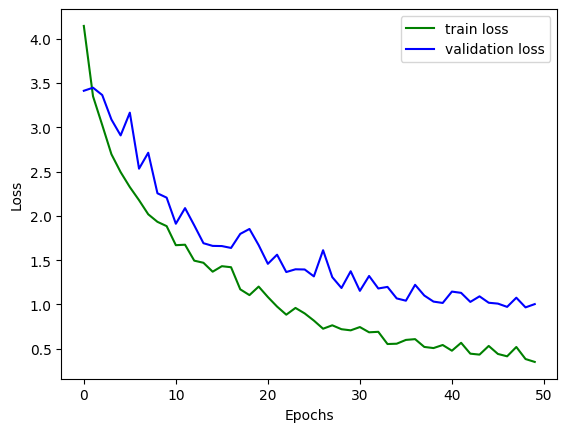

In [29]:
epochs = range(0,n_epochs)
plt.plot(epochs, loss_list, 'g', label='train loss')
plt.plot(epochs, val_loss_list, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
torch.save(detector.state_dict(), "/content/drive/MyDrive/model.pt")

In [31]:
total_loss = 0
cnt = 0
with torch.no_grad():
  for img_batch, gt_bboxes_batch in tst_data_loader:
    cnt = cnt + 1
    gt_classes_batch = torch.tensor([[1.0], [1.0]])
    # forward pass
    loss = detector(img_batch.to(device), gt_bboxes_batch.to(device), gt_classes_batch.to(device))
    # backpropagation

    total_loss += loss.item()
  total_loss = total_loss / cnt
print("Test loss is: ", total_loss)

Test loss is:  1.57414825811973


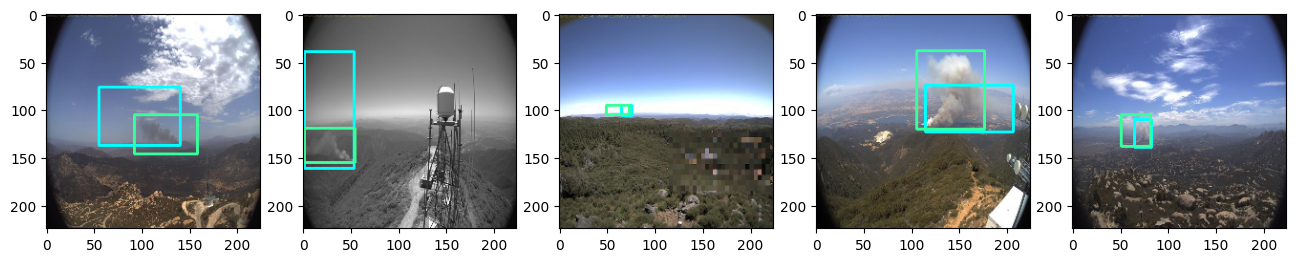

In [32]:
detector = detector.cpu()
fig, axes = plt.subplots(1, 5, figsize=(16, 8))
i = 0
with torch.no_grad():
  for img_batch, gt_bboxes_batch in tst_data_loader:

    proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)
    img = cv2.cvtColor(img_batch[0].permute(1, 2, 0).numpy().astype(np.uint8), cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    anc_boxes_proj = proposals_final[0]


    # project anchor boxes to the image
    bboxes = anc_boxes_proj[0]



    bboxes = ops.box_convert(bboxes, in_fmt='xyxy', out_fmt='xywh')
    for box in [bboxes]:
      x, y, w, h = box.numpy()*16
      # display bounding box
      cv2.rectangle(img,(int(x),int(y)),(int(x+w),int(y+h)),(0,255,255),2)

    for box in gt_bboxes_batch[0]:
      x, y, w, h = box.numpy()
      # display bounding box
      cv2.rectangle(img,(int(box[0]),int(box[1])),(int(box[2]),int(box[3])),(55,255,155),2)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    i += 1
    if (i >= 5):
      break